In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm

import pandas as pd
import os 
from glob import glob

import numpy as np
import cv2

import albumentations

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset

In [4]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs
from src.modules import dataset as ds
from src.modules import metrics as ms
from src.modules import augmentations as augs
from src.modules import learner as lrn
# from retinanet import model as retinanet
import src.models.retinanet.resnext
import src.models.retinanet.model
from src.models.retinanet import model as retinanet

%load_ext autoreload
%autoreload 2

In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
labels = pd.read_csv(os.path.join(config.PATHS.CSV, 'labels.csv'))

In [7]:
folds = ds.get_folds(labels, 4)
fold = ds.get_fold_split(folds, 0)
train_dataset = ds.BBoxDataset(labels, fold[0], augmentations=augs.Augmentation())
valid_dataset = ds.BBoxDataset(labels, fold[1])
vtrain_dataset = ds.BBoxDataset(labels, fold[0])

In [8]:
train_datagen = DataLoader(train_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True, collate_fn=ds.bbox_collater)
valid_datagen = DataLoader(valid_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=False, collate_fn=ds.bbox_collater)
vtrain_datagen = DataLoader(vtrain_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True, collate_fn=ds.bbox_collater)
for data in train_datagen:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


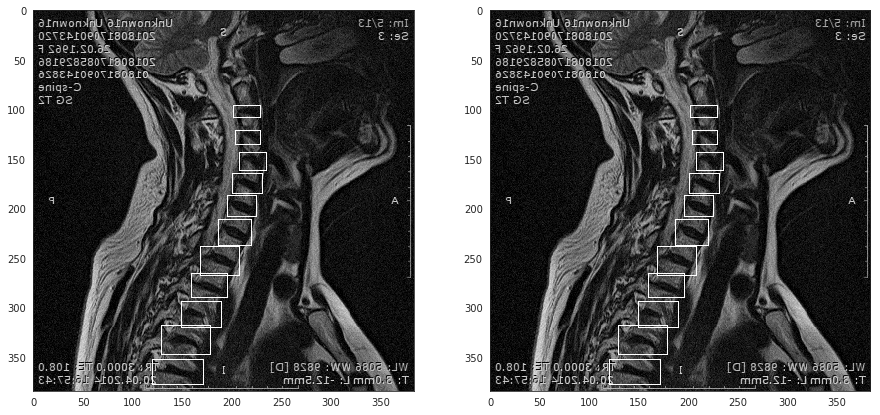

In [9]:
data = train_dataset[55]
img = vs.visualize_bboxes(data, data, {1: 'normal', 0: 'pathology'})

In [10]:
focal_loss = retinanet.FocalLoss(iou_lower=.3, iou_upper=.5)
model = retinanet.resnet34(num_classes=2, focal_loss=focal_loss, pretrained=True, single_channel=True, make_clf=False)

opt = torch.optim.Adam(model.parameters(), lr=5e-4)
model = lrn.get_model(model, devices=config.PARAMS.CUDA_DEVICES)

learner = lrn.RetinaLearner(model, opt)

Overlapped keys: 180
Poped keys: []
Summed over: weight


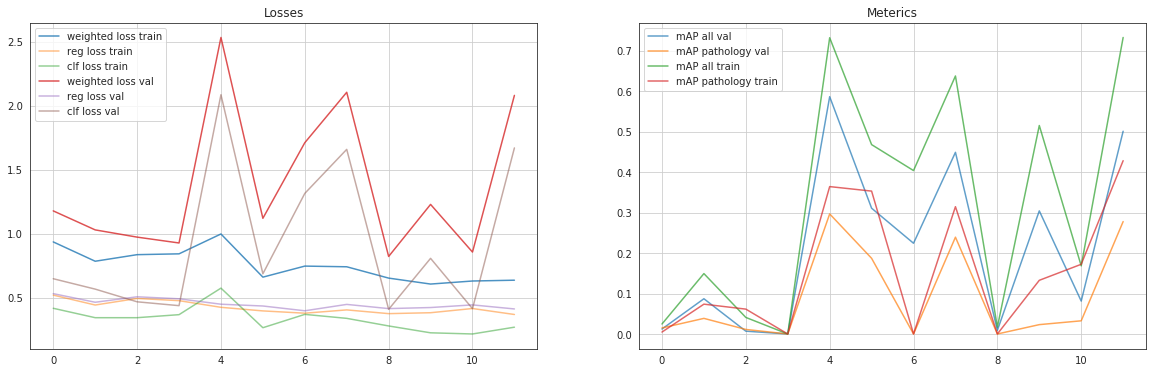

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


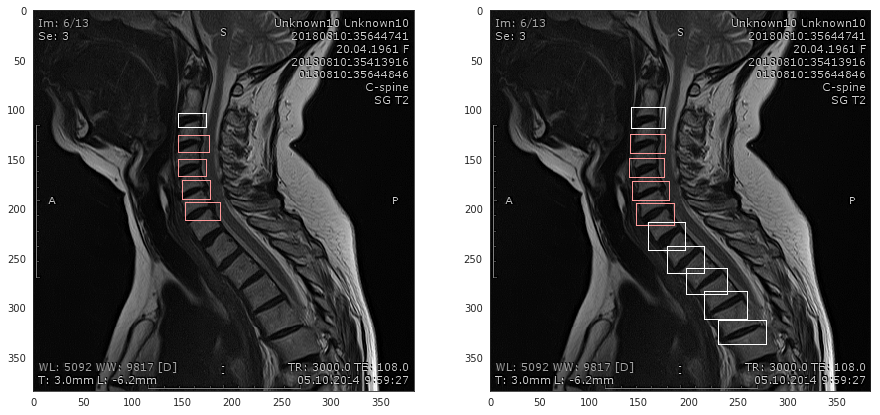

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 12


  4%|▍         | 12/267 [00:00<00:08, 31.78it/s]

In [ ]:
from collections import defaultdict


history = defaultdict(list)
for i in range(50):
    
    print('Epoch: {}'.format(i))
    learner.train_on_epoch(train_datagen)

    el = learner.validate(vtrain_datagen)
    metr = ms.estimate_pred(el)
    history['train'].append(metr)

    el = learner.validate(valid_datagen)
    metr = ms.estimate_pred(el)
    history['valid'].append(metr)
    clear_output(wait=True)
    vs.plot_losses(history)
    vs.visualise_pred(el[0])